In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("../data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [3]:
print('The size:\n', data.shape, '\n')
print('Duplicates:\n', sum(data.duplicated()), '\n')
print('The number of NA:\n', data.isnull().sum())

The size:
 (17996, 17) 

Duplicates:
 0 

The number of NA:
 Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64


### Data type checking

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [5]:
for column_name in data.columns:
    if data[column_name].nunique() < 15:
        print(column_name, str(data[column_name].unique()))

key [ 1.  3.  6. 10.  2.  5.  7.  9. 11.  8. nan  4.]
mode [1 0]
time_signature [4 3 1 5]
Class [ 5 10  6  2  4  8  9  3  7  1  0]


In [6]:
data[["key"]] = data[["key"]].astype("category")
data[["mode"]] = data[["mode"]].astype("category")
data[["time_signature"]] = data[["time_signature"]].astype("category")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Artist Name         17996 non-null  object  
 1   Track Name          17996 non-null  object  
 2   Popularity          17568 non-null  float64 
 3   danceability        17996 non-null  float64 
 4   energy              17996 non-null  float64 
 5   key                 15982 non-null  category
 6   loudness            17996 non-null  float64 
 7   mode                17996 non-null  category
 8   speechiness         17996 non-null  float64 
 9   acousticness        17996 non-null  float64 
 10  instrumentalness    13619 non-null  float64 
 11  liveness            17996 non-null  float64 
 12  valence             17996 non-null  float64 
 13  tempo               17996 non-null  float64 
 14  duration_in min/ms  17996 non-null  float64 
 15  time_signature      17996 non-null  

### Distribution checking

In [8]:
data.describe()

,Popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,Class
count,17568.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000
mean,44.512124,0.543433,0.662777,-7.910660,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,6.695821
std,17.426928,0.166268,0.235373,4.049151,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,3.206073
min,1.000000,0.059600,0.000020,-39.952000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,0.000000
25%,33.000000,0.432000,0.509000,-9.538000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,5.000000
50%,44.000000,0.545000,0.700000,-7.016000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,8.000000
75%,56.000000,0.659000,0.860000,-5.189000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,10.000000
max,100.000000,0.989000,1.000000,1.355000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,10.000000


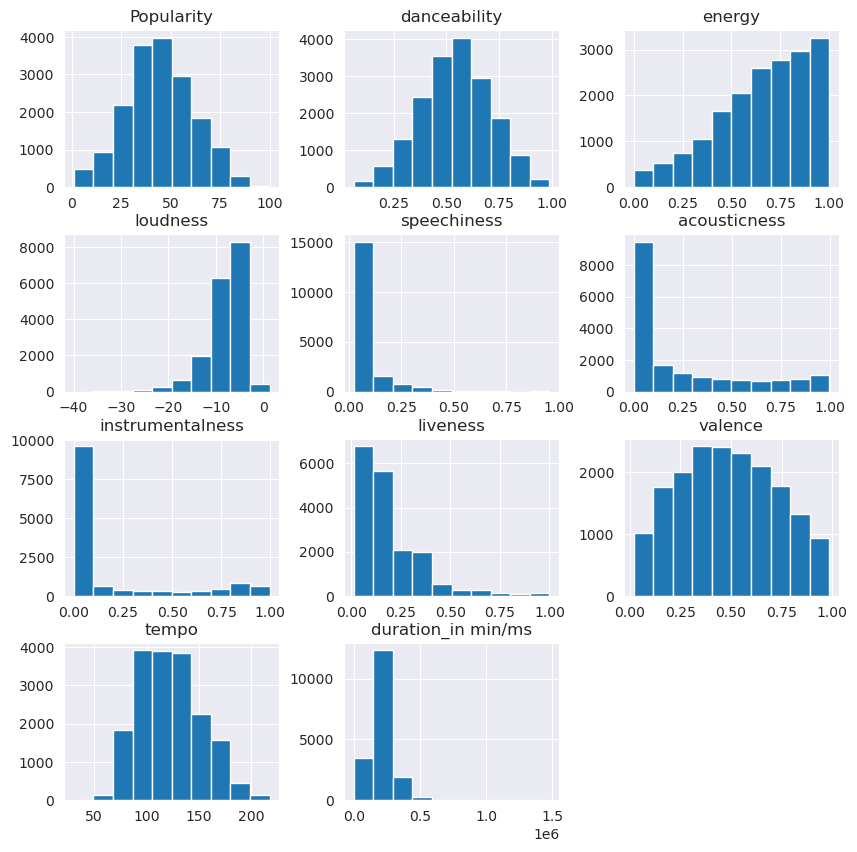

In [9]:
data[data.columns[:-2]].hist(figsize=[10,10])
pass

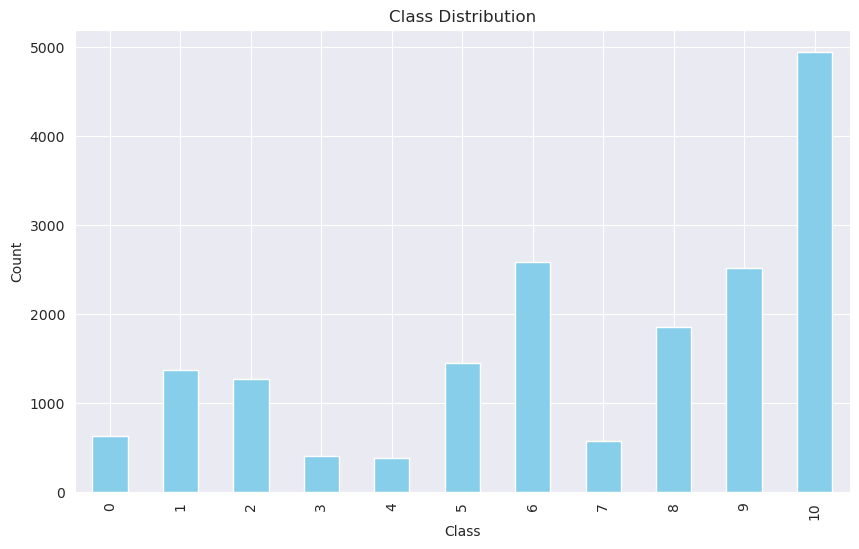

Class
0      625
1     1373
2     1272
3      402
4      387
5     1447
6     2587
7      576
8     1854
9     2524
10    4949
dtype: int64

In [10]:
plt.figure(figsize=(10, 6))
data['Class'].value_counts().sort_index().plot(kind='bar', color = 'skyblue', title = 'Class Distribution', ylabel = 'Count', xlabel = 'Class')
plt.show()

data.groupby('Class').size()

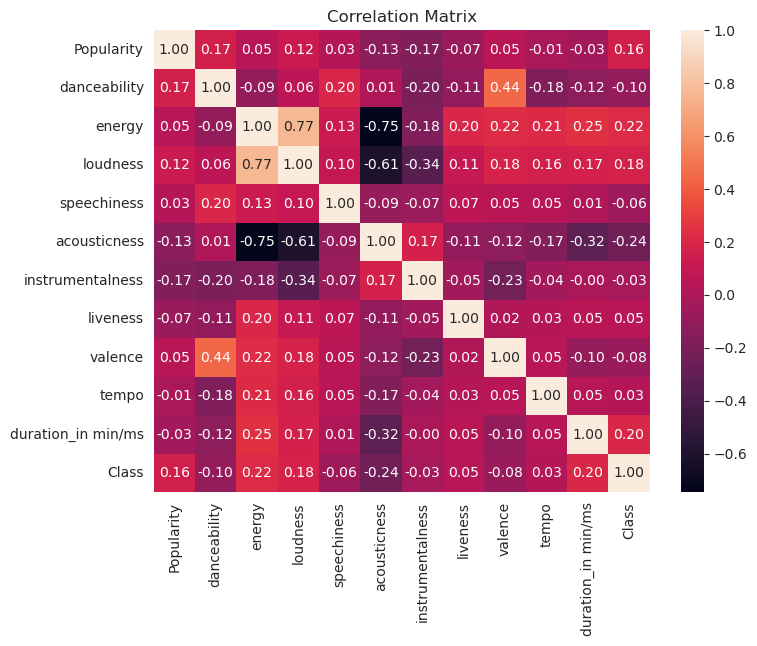

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.select_dtypes(['float64', 'int64']).corr(), fmt='.2f', annot=True)
plt.title('Correlation Matrix')
plt.show()

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

### Подготовка данных

Избавимся от Nan

In [16]:
data["key"] = data["key"].fillna(data["key"].mode()[0])
data["Popularity"] = data["Popularity"].fillna(data["Popularity"].mode()[0])
data["instrumentalness"] =  data["instrumentalness"].fillna(data["instrumentalness"].median())

Удалим первые две колонки и колонку y

In [17]:
data_tree = data.drop(columns=['Artist Name', 'Track Name', 'Class'])
data_tree.head(2)

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.0171,0.00391,0.0849,0.899,134.071,234596.0,4
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.0011,0.00401,0.1010,0.569,116.454,251733.0,4


Готовим test и train выборки

In [18]:
X = data_tree
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Подбор параметров

In [42]:
import warnings
warnings.filterwarnings('ignore')

param_grid = {
    'max_depth': range(1, 30),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 4),
    'criterion': ['gini', 'entropy']}

tree = DecisionTreeClassifier()
grid_search = GridSearchCV(tree, param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 10)})

In [43]:
best_score = grid_search.best_params_
print(best_score)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7}


In [44]:
model = grid_search.best_estimator_

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.4823294065347855

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.
Давно не смотрела что-то реально впечатляющее меня. Надеюсь, список ответов однокурсников будет опубликован, потому что безумно интересно.
Немного из того, что когда-то мне понравилось:

1. Начало (На самом деле не люблю фантастику, но понравилась их вселенная).

2. Великий Гэтсби (Мне отзываются истории дружбы и знакомств, взаимоотношений с интересными и значимыми в жизни людьми, к тому же атмосфера эпохи. Возможно, лучше книга, но я не читала.)

3. Король говорит (Нравятся фильмы о преодолении реальных жизненных трудностей, влиянии людей друг на друга. Сюда же могу отнести "Дьявол носит Prada".)